트리 기반 기법

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data_raw = pd.read_csv('data_ml.csv')
idx_date = data_raw.index[(
    data_raw['date'] > '1999-12-31') & (
    data_raw['date'] < '2019-01-01')].tolist()
#날짜를 받기 위한 인덱스 생성
data_ml = data_raw.iloc[idx_date]
#날짜 인덱스에 따라 데이터셋 필터링
data_ml.iloc[0:6, 0:6]

features = list(data_ml.iloc[:, 3:95].columns)
# 특성의 열 이름 저장 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd",
                  "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

separation_date = "2014-01-15"
idx_train = data_ml.index[(data_ml['date']<separation_date)].tolist()
idx_test = data_ml.index[(data_ml['date']>=separation_date)].tolist()
training_sample = data_ml[data_ml.index.isin(idx_train)]
testing_sample = data_ml[data_ml.index.isin(idx_test)]

6.1 단순 트리

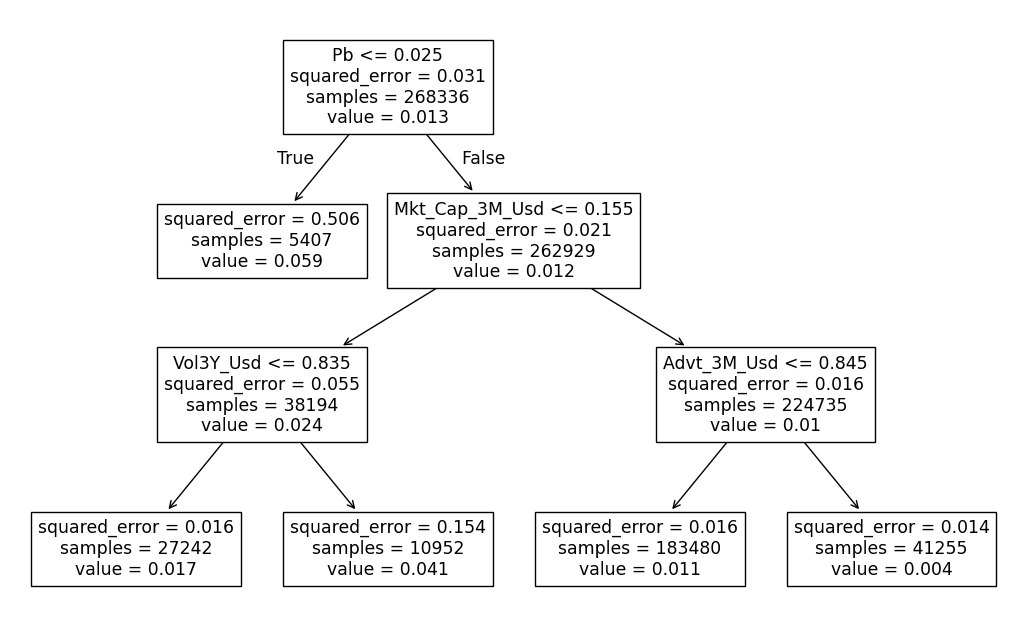

In [3]:
from sklearn import tree
X = data_ml.iloc[:, 3:95]
y = data_ml['R1M_Usd']

fit_tree = tree.DecisionTreeRegressor(
    min_samples_split=8000,
    max_depth= 3,
    ccp_alpha= 0.000001,
    min_samples_leaf= 3500
    )

fit_tree.fit(X, y)
fig, ax = plt.subplots(figsize=(13,8))
tree.plot_tree(fit_tree, feature_names = X.columns.values, ax=ax)
plt.show()

In [4]:
y_pred = fit_tree.predict(X.iloc[0:6, :])
print(f'y_pred: {y_pred}')

y_pred: [0.01088066 0.01088066 0.01088066 0.01088066 0.04133053 0.04133053]


<Figure size 18000x6000 with 0 Axes>

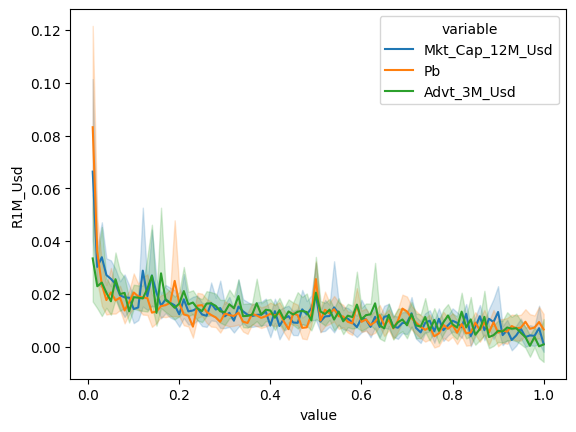

<Figure size 18000x6000 with 0 Axes>

In [5]:
import seaborn as sns
unpivoted_data_ml = pd.melt(
    data_ml[['R1M_Usd', 'Mkt_Cap_12M_Usd', 'Pb', 'Advt_3M_Usd']],
    id_vars= 'R1M_Usd'
    )

sns.lineplot(data = unpivoted_data_ml, y='R1M_Usd', x='value', hue='variable')
plt.figure(figsize=(15,5), dpi = 1200)

In [5]:
y_train = training_sample['R1M_Usd'].values
X_train = training_sample[features].values

y_test = testing_sample['R1M_Usd'].values
X_test = testing_sample[features].values

fit_tree2 = tree.DecisionTreeRegressor(
    min_samples_split = 4000,
    max_depth = 5,
    ccp_alpha = 0.0001,
    min_samples_leaf = 1500
        )
fit_tree2 = fit_tree2.fit(X_train, y_train)

mse = np.mean((fit_tree2.predict(X_test) - y_test) ** 2)
print(f'MSE: {mse}')
hitratio = np.mean(fit_tree2.predict(X_test)*y_test>0)
print(f'Hit Ratio : {hitratio}')

MSE: 0.036996958091850045
Hit Ratio : 0.5460346399270738


6.2 랜덤 포레스트

In [7]:
from sklearn.ensemble import RandomForestRegressor
fit_RF = RandomForestRegressor(n_estimators= 40,
                               criterion='squared_error',
                               min_samples_split=250,
                               bootstrap=True,
                               max_features=30,
                               max_samples=10000
                               )

fit_RF.fit(X_train, y_train)
fit_RF.predict(pd.DataFrame(X_test).iloc[0:5,])

array([0.13855472, 0.14778656, 0.14775198, 0.151215  , 0.13172237])

In [8]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, fit_RF.predict(X_test))
print(f'MSE: {mse}')
hitratio = np.mean(fit_RF.predict(X_test) * y_test >0)
print(f'Hit Ratio: {hitratio}')

MSE: 0.036874370538841766
Hit Ratio: 0.5371182771194166


In [9]:
df_median = []
df = []

import numpy as np
df_median = data_ml[['date', 'R1M_Usd', 'R12M_Usd']].groupby(
    ['date']).median()
df_median.rename(
    columns={"R1M_Usd": "R1M_Usd_median",
             "R12M_Usd": "R12M_Usd_median"}, inplace=True)

df = pd.merge(data_ml, df_median, how='left', on=['date'])

data_ml['R1M_Usd_C'] = np.where(
    df['R1M_Usd'] > df['R1M_Usd_median'], 1.0, 0.0)
data_ml['R12M_Usd_C'] = np.where(
    df['R12M_Usd'] > df['R12M_Usd_median'], 1.0, 0.0)

idx_train = data_ml.index[(data_ml['date']<separation_date)].tolist()
idx_test = data_ml.index[(data_ml['date']>=separation_date)].tolist()
training_sample = data_ml[data_ml.index.isin(idx_train)]
testing_sample = data_ml[data_ml.index.isin(idx_test)]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15032\3040760903.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R1M_Usd_C'] = np.where(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15032\3040760903.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R12M_Usd_C'] = np.where(


In [10]:
from sklearn.ensemble import RandomForestClassifier
fit_RF_C = RandomForestClassifier(
    n_estimators=40,
    criterion='gini',
    min_samples_split=250,
    bootstrap=True,
    max_features=30,
    max_samples=20000
)
y_c_train = training_sample['R1M_Usd_C'].values
y_c_test = testing_sample['R1M_Usd_C'].values

fit_RF_C = fit_RF_C.fit(X_train, y_c_train)
hitratio = np.mean(fit_RF_C.predict(X_test) == y_c_test)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5030623290793071


6.3 부스트 트리 : 에이다부스트

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
fit_adaboost_C = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=3)
fit_adaboost_C.fit(X_train, y_c_train)

c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=3)

In [12]:
from sklearn.metrics import accuracy_score
hitratio = accuracy_score(y_c_test, fit_adaboost_C.predict(X_test))
print(f'Hit Ratio : {hitratio}')

Hit Ratio : 0.49641066545123064


6.4 익스트림 그레디언트 부스팅 (XGBoost)

In [13]:
import xgboost as xgb
data_ml.loc[:, 'R1M_Usd_quantile'] = data_ml.groupby('date')['R1M_Usd'].transform(
    lambda x: pd.qcut(x, 100, labels=False, duplicates=('drop'), precision=50)
)
separation_mask = data_ml['date'] < separation_date

# 행 선택을 위한 불리언 배열
boolean_quantile = (
    (data_ml.loc[separation_mask, 'R1M_Usd_quantile']<=20)|
    (data_ml.loc[separation_mask, 'R1M_Usd_quantile']>=80)
)
# 극단치 선택
train_features_xgb = training_sample.loc[boolean_quantile, features_short]
train_label_xgb = training_sample.loc[boolean_quantile, 'R1M_Usd']
train_features_xgb = train_features_xgb.to_numpy()
train_label_xgb = train_label_xgb.to_numpy()

train_matrix_xgb = xgb.DMatrix(train_features_xgb, label=train_label_xgb)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15032\4049837985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml.loc[:, 'R1M_Usd_quantile'] = data_ml.groupby('date')['R1M_Usd'].transform(


3가지 제약 조건 사용  
1. 시가총액(사이즈 이상현상)  
2. 장부가 대비 주가 비율(밸류 이상 현상)  
3. 과거 연간 수익률(모멘텀 이상 현상)

In [14]:
# 벡터 초기화 -1: 감소, +1: 증가
# 시가총액 감소 mono_const[2]
# 과거 수익률 상승 mono_const[3]
# 장부가 대비 시장가 하락 mono_const[5]
mono_const="(0, 0, -1, 1, 0, -1, 0)"


In [18]:
params={'eta':0.3, #학습률
        'objective':"reg:squarederror", #목적함수 
        'max_depth':4, #트리의 최고 깊이
        'subsample':0.6, #샘플 중 무작위적으로 60%를 선택해 훈련
        'colsample_bytree':0.7, #예측 인자 중 무작위적으로 70%를 선택해 훈련
        'lambda':1, #나뭇잎 값에 대한 규제화
        'gamma':0.1, #나뭇잎 개수에 대한 규제화
        'nrounds':30, #사용한 트리 개수
        'monotone_constraints':mono_const, #단조성 제약 조건
        'rate_drop':0.1, #DART를 위한 드롭률
        'verbose':0} #메시지 없음
fit_xgb = xgb.train(params, train_matrix_xgb)

c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:27:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "nrounds", "rate_drop", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [22]:
test_features_xgb = testing_sample[features_short]
test_matrix_xgb = xgb.DMatrix(test_features_xgb)

y_pred = fit_xgb.predict(test_matrix_xgb)
mse = np.mean((y_pred - y_test) ** 2)
print(f'MSE: {mse}')
hitratio = np.mean(y_pred * y_test >0)
print(f'hitratio : {hitratio}')

MSE: 0.03664451536507834
hitratio : 0.5089448495897904


xgboost하에서의 분류작업

In [23]:
train_label_xgb_C = training_sample.loc[boolean_quantile, 'R1M_Usd_C']
train_matrix_xgb_C=xgb.DMatrix(train_features_xgb, label=train_label_xgb_C)

In [24]:
params_C={'eta':0.8,
          'objective':"multi:softmax",
          'max_depth':4,
          'num_class':2,
          'nrounds':10,
          'verbose':0}
fit_xgb_C = xgb.train(params_C, train_matrix_xgb_C)

c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "nrounds", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [25]:
hitratio = np.mean(fit_xgb_C.predict(test_matrix_xgb)==y_c_test)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.49549908842297175


인스턴스 가중치 부여

In [29]:
inst_weights = np.random.uniform(0,10,(train_features_xgb.shape[0],1))
train_matrix_xgb = xgb.DMatrix(train_features_xgb, label=train_label_xgb, weight=inst_weights)

In [30]:
hitratio = np.mean(fit_xgb_C.predict(test_matrix_xgb)==y_c_test)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.49549908842297175


6.6 코딩예제

1. 위에서 나온 공식을 사용해 훈련 샘플에 매개 변수가 cp 하나만 있는 2개의 간단한 트리  
첫번째 트리의 경우 cp=0.001, 두번째 트리의 경우 cp=0.01을 사용.  
테스트 샘플에서 두 모델의 성능 평가.

In [6]:
fit1 = tree.DecisionTreeRegressor(
    max_depth=5,
    ccp_alpha=0.00001
)

fit1.fit(X,y)
mse = np.mean((fit1.predict(X_test) - y_test) **2)
print(f'MSE: {mse}')
hitratio = np.mean(fit1.predict(X_test)*y_test>0)
print(f'Hit Ratio : {hitratio}')

MSE: 0.014679220247642136
Hit Ratio : 0.5460346399270738


c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [8]:
fit2 = tree.DecisionTreeRegressor(
    max_depth=5,
    ccp_alpha=0.001
)

fit2.fit(X,y)
mse = np.mean((fit2.predict(X_test) - y_test) **2)
print(f'MSE: {mse}')
hitratio = np.mean(fit2.predict(X_test)*y_test>0)
print(f'Hit Ratio : {hitratio}')

MSE: 0.02400906644860041
Hit Ratio : 0.5460346399270738


c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


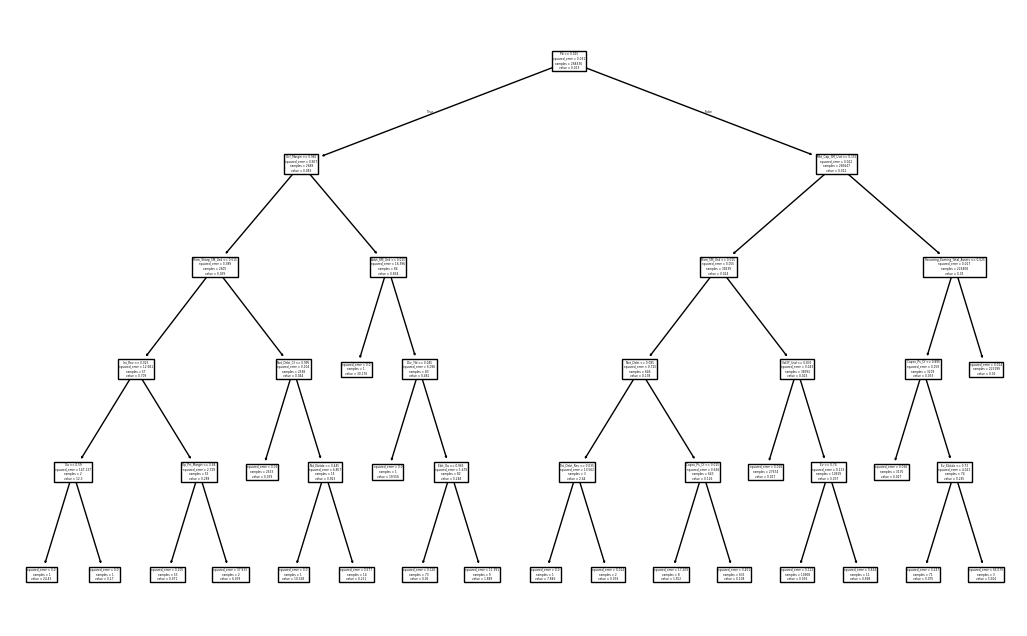

In [9]:
fig, ax = plt.subplots(figsize=(13,8))
tree.plot_tree(fit1, feature_names=X.columns.values, ax=ax)
plt.show()

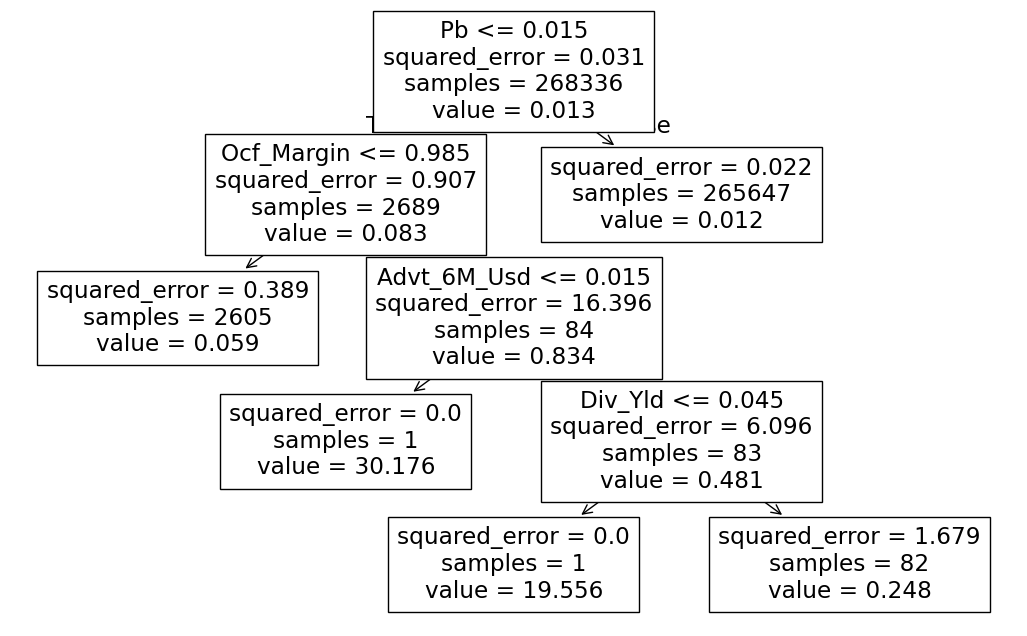

In [12]:
fig, ax = plt.subplots(figsize=(13,8))
tree.plot_tree(fit2, feature_names=X.columns.values, ax=ax)
plt.show()

In [ ]:
# 후자의 경우가 MSE 가 더 좋은 수치로 나온다. 첫번째 모델은 과적합 된 것으로 보인다.

2. 더 작은 예측 인자 집합 사용- 훈련 샘플로 랜덤 포레스트 구축  
30000개의 인스턴스 / 5개 이상의 예측 인자로 제한, 10,20,40,80,160개의 나무에 대한 포레스트 구축, 훈련 샘플 성능 평가.  
이 경우 복잡성에 가치가 있는가? 그렇다면 왜인가?

In [11]:
from sklearn.ensemble import RandomForestRegressor

n_trees = [10,20,40,80,160]
mse_rf = []
hitratio_rf = []

for i in range(len(n_trees)):
    fit_RF1 = RandomForestRegressor(n_estimators= n_trees[i],
                                    criterion='squared_error',
                                    bootstrap=True,
                                    max_depth=5,
                                    max_samples=30000)
    fit_RF1.fit(X_train, y_train)
    mse = np.mean((fit_RF1.predict(X_test) - y_test) **2)
    mse_rf.append([mse])
    hitratio = np.mean(fit_RF1.predict(X_test)*y_test>0)
    hitratio_rf.append([hitratio])

print(mse_rf)
print(hitratio_rf)

[[np.float64(0.037611014388779514)], [np.float64(0.036959124236005246)], [np.float64(0.03699480802039537)], [np.float64(0.03647576679308934)], [np.float64(0.03653740547478697)]]
[[np.float64(0.545621581586144)], [np.float64(0.5458779626253418)], [np.float64(0.5458352324521422)], [np.float64(0.5457925022789426)], [np.float64(0.5458067456700091)]]


In [ ]:
# 전반적으로 많은 수의 트리가 유의미해보인다. 
# 그러나 트리의 개수 증가 속도에 완전히 비례하여 결과가 성장하는 것 같아 보이지는 않는다.
# 이는 브레이만(2001)에 변수별로 나와있으며, 전체 숲의 위험을 분산하기 위해서 유의미한 것은 사실이다.

3. 2008년 데이터로 트리를 시각화하고 2009년에 대해서도 시각화한 후 둘을 비교하라.

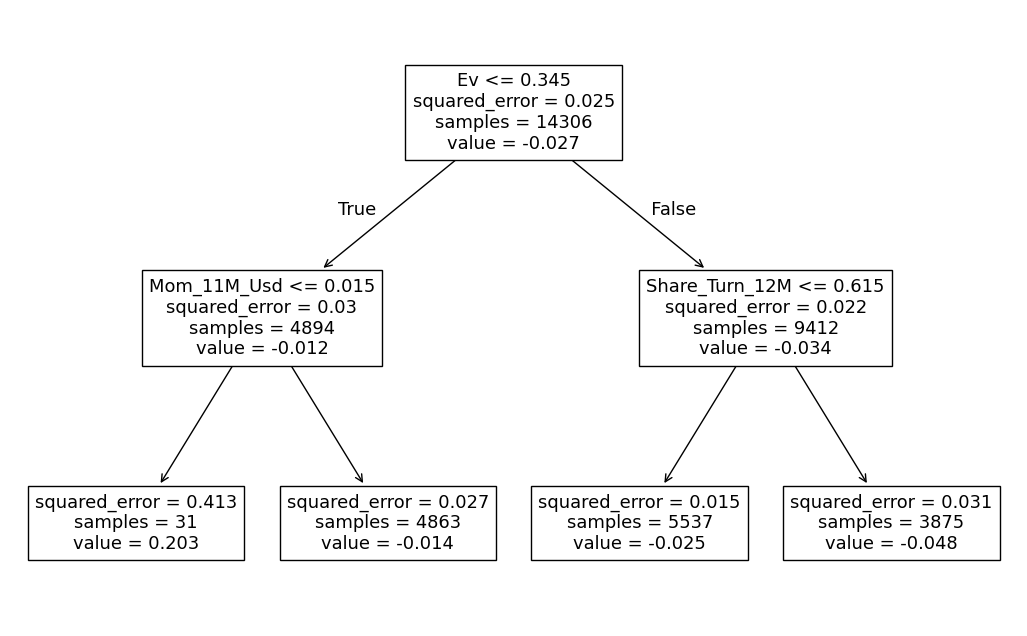

In [18]:
training_sample_2008 = training_sample.loc[training_sample.index[
    (training_sample['date'] > '2007-12-31') & (training_sample['date'] < '2009-01-01')].tolist()]
training_sample_2009 = training_sample.loc[training_sample.index[
    (training_sample['date'] > '2008-12-31') & (training_sample['date'] < '2010-01-01')].tolist()]

fit_2008 = tree.DecisionTreeRegressor(
    max_depth = 2,
    ccp_alpha= 0.00001,
)
fit_2008.fit(training_sample_2008.iloc[:, 3:95], training_sample_2008['R1M_Usd'])
fig, ax = plt.subplots(figsize=(13,8))
tree.plot_tree(fit_2008, feature_names=X.columns.values, ax=ax)
plt.show()

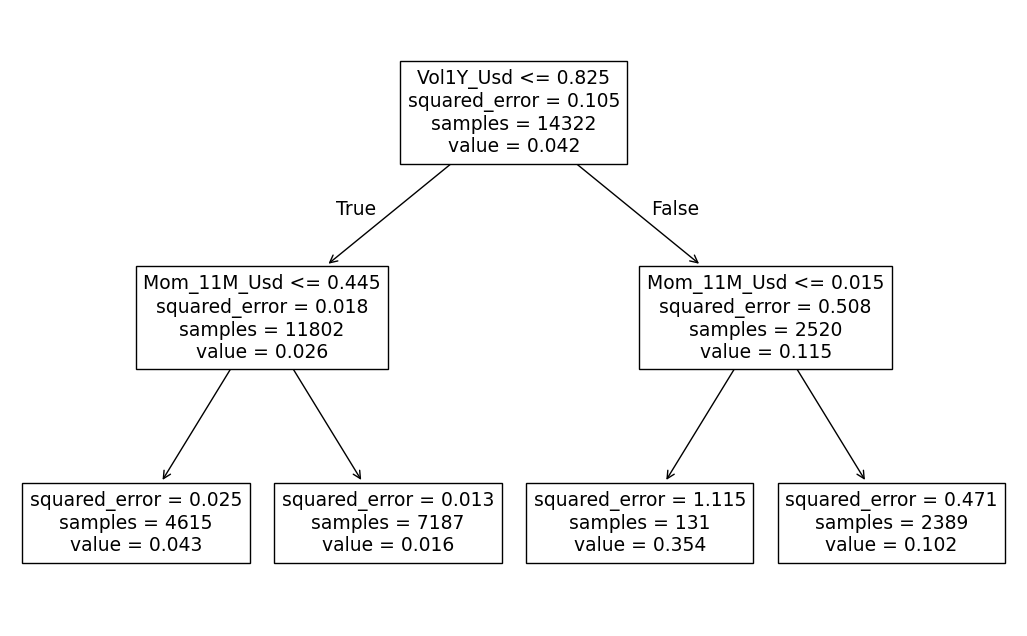

In [20]:
fit_2009 = tree.DecisionTreeRegressor(
    max_depth = 2,
    ccp_alpha= 0.00001,
)
fit_2009.fit(training_sample_2009.iloc[:, 3:95], training_sample_2009['R1M_Usd'])
fig, ax = plt.subplots(figsize=(13,8))
tree.plot_tree(fit_2009, feature_names=X.columns.values, ax=ax)
plt.show()

In [21]:
"""
2008년의 경우 EV가 높은 기업이 가장 낮은 성과를 보였다.
또한 EV가 낮고 MOM 11M 가 낮은 기업이 가장 높은 성과를 보였다.
2009년에는 1년간의 변동성이 가장 높고 Mom 11M 가 낮은 기업이 가장 큰 성과를 보였다.
또한 변동성이 낮고 MoM 11M 가 높은 기업이 가장 낮은 성과를 보였다.

전반적으로 2008년에 비해 2009년이 좋은 성과를 보이는데,
2008년의 블랙스완 이후 가치에 비해 가격이 가장 많이 절하될수록, 2009년에 더 좋은 성과를 보이는 듯 하다.
즉, 과거 성과가 낮았던 자산 (모멘텀 팩터의 숏 구간)이 반등하며 큰 성과를 보이며, 모멘텀 롱구간은 상대적으로 낮은 성과를 보인다.
모멘텀 팩터의 반전 효과가 나타났다고 볼 수 있다.

모멘텀 팩터는 안정적인 시장 상황에서 좀더 강점이 있으며, 큰 하락기 이후에 가치 회복을 기대한다면 모멘텀 숏 포지션을 하는 것이 긍정적으로 보인다.
"""

'\n2008년의 경우 EV가 높은 기업이 가장 낮은 성과를 보였다.\n또한 EV가 낮고 MOM 11M 가 낮은 기업이 가장 높은 성과를 보였다.\n2009년에는 1년간의 변동성이 가장 높고 Mom 11M 가 낮은 기업이 가장 큰 성과를 보였다.\n또한 변동성이 낮고 MoM 11M 가 높은 기업이 가장 낮은 성과를 보였다.\n\n전반적으로 2008년에 비해 2009년이 좋은 성과를 보이는데,\n2008년의 블랙스완 이후 가치에 비해 가격이 가장 많이 절하될수록, 2009년에 더 좋은 성과를 보이는 듯 하다.\n즉, 과거 성과가 낮았던 자산 (모멘텀 팩터의 숏 구간)이 반등하며 큰 성과를 보이며, 모멘텀 롱구간은 상대적으로 낮은 성과를 보인다.\n모멘텀 팩터의 반전 효과가 나타났다고 볼 수 있다.\n\n모멘텀 팩터는 안정적인 시장 상황에서 좀더 강점이 있으며, 큰 하락기 이후에 가치 회복을 기대한다면 모멘텀 숏 포지션을 하는 것이 긍정적으로 보인다.\n'